<center>
<img src='https://camo.githubusercontent.com/88b0ce29beb6724c1ba363b7e025cfe33fb19baee23a88418d78fdc2ad9bc140/68747470733a2f2f7777772e71756f74656d61737465722e6f72672f696d616765732f36632f36636434343032613361343731646633346561346539323332666536643363642e6a7067' align='center' width="300x">
</center>

# Андан на экономе

## Семинар 6: введение в машинное обучение

В этом семинаре мы с вами обсудим, что такое машинное обучение. Мы введём все основные термины и попробуем обучить свои первые модели.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Зачем нужно машинное обучение?

В этой части семинара ваш семенарист сделает красочный интересный рассказ о том что такое машинное обучение и зачем оно нужно.

<center>
<img src='https://raw.githubusercontent.com/Vasyka/intro-ml-bi/main/week02/scheme.png' align='center' width="600x">
</center>

Из этого красочного рассказа вы узнаете:

1. Чем занимается машинное обучение 
2. Какиеми бывают задачи машинного оубчения
3. Что такое обучающая выборка и обучение с учителем
4. Какими бывают переменные объясняющие/объясняемые, непрерывные/категориальные/бинарные/другое (тексты/картинки и тп)
5. Какими бывают модели и о каких из них мы будем говорить (линейные модели и KNN)
6. Как измерить качество модели и зачем разбивать выборку на обучаюшую и тестовую
7. Что такое кросс-валидация и почему разбить выборку на обучающую и тестовую недостаточно

Все эти понятия есть в [конспекте от Жени Соколова.](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/lecture-notes/lecture01-intro.pdf) Очень рекомендуем прочитать его.

# 2. Данные и переменные

Сегодня мы познакомимся с задачей регрессии. Будем работать с данными о рекламе и продажах. У нас есть 200 рынков. На каждом из них мы инвестировали в разную рекламу какую-то сумму.

- `TV` - доллары, потраченные на ТВ рекламу для одного продукта на данном рынке (в тысячах долларов)
- `Radio` - доллары, потраченные на радио рекламу
- `Newspaper` - доллары, потраченные на рекламу в газетах
- `Area` - в какой зоне происходила реклама (сельская, пригород, город)
- `Sales` - продажи одного продукта на данном рынке (в тысячах)

Будем предсказывать продажи. Они будут нашей __целевой переменной.__ Остальные переменные будут __объясняющими.__ 

In [2]:
df = pd.read_csv('Advertising.csv')
print(df.shape)
df.head()

(200, 5)


,TV,Radio,Newspaper,Sales,Area
0,230.1,37.8,69.2,22.1,suburban
1,44.5,39.3,45.1,10.4,urban
2,17.2,45.9,69.3,9.3,rural
3,151.5,41.3,58.5,18.5,rural
4,180.8,10.8,58.4,12.9,suburban


## 2.1 Объясняемая переменная

Продажи - наша объясняемая переменная. Давайте посмотрим на её распределение и убедимся, что в ней нет выбросов. 

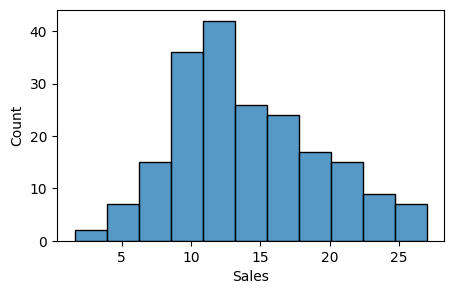

In [3]:
plt.figure(figsize=(5,3))
sns.histplot(df.Sales);

__Вопрос:__ Что такое выбросы? Как думаете, почему они могут нам навредить? 

Давайте посмотрим как объясняемая переменная связана с объясняющими. Построим для этого облака рассеивания.

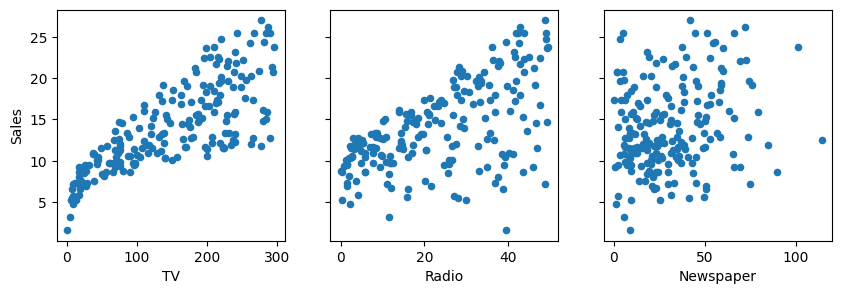

In [4]:
fig, axs = plt.subplots(1, 3, sharey=True)

df.plot(kind='scatter', x='TV', y='Sales', ax=axs[0], figsize=(10, 3))
df.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
df.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2]);

__Вопрос:__ Какие зависимости вы видите? Какую линию вам хочется провести сквозь облака точек? 

Давайте попробуем посчитать корреляцию между продажами и остальными переменными.

In [5]:
df[['TV', 'Radio', 'Newspaper']].corrwith(df['Sales'])

TV           0.782224
Radio        0.576223
Newspaper    0.228299
dtype: float64

Попробуем прологарифмировать переменные и снова посмотрим на картинки и корреляцию.

In [6]:
df_log = df[['TV', 'Radio', 'Newspaper', 'Sales']].apply(lambda w: np.log(w + 1))

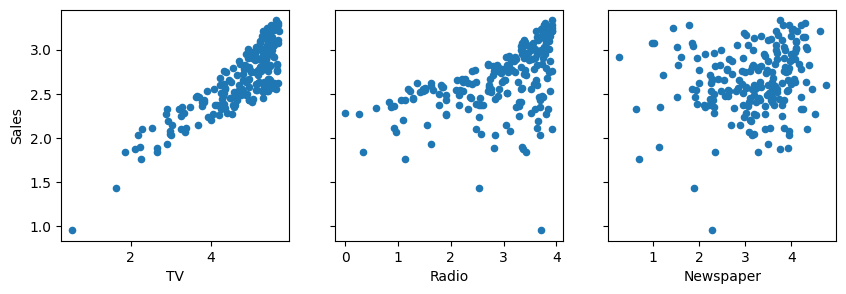

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True)

df_log.plot(kind='scatter', x='TV', y='Sales', ax=axs[0], figsize=(10, 3))
df_log.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
df_log.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2]);

In [8]:
df_log[['TV', 'Radio', 'Newspaper']].corrwith(df_log['Sales'])

TV           0.851895
Radio        0.475380
Newspaper    0.167691
dtype: float64

__Вопрос:__ Что произошло с картинками и корреляцией? Как думаете, что это означает?

## 2.2 Объясняющие переменные

Все переменные из таблички можно поделить на две части: непрерывные и категориальные. Делать их предобработку нужно по-разному. 

* непрерывные переменные принимают любые действительные значения
* категориальные принимают значения из ограниченного множества значений

### Непрерывные переменные 

При предварительном анализе непрерывных переменных обычно смотрят на следующие проблемы. 

__1) Пропуски.__

В данных могут встречаться пропущенные значения. Их надо предобработать. Многие модели не умеют работать с пропусками. Если пропусков немного, можно удалить объекты с пропусками из обучающей выборки. Заполнить пропуски можно разными способами:

* заполнить средними (mean, median);
* предсказывать пропущенные значения по непропущенным.

Последний вариант сложный и применяется редко. Посмотрим на наши данные.

In [9]:
df.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
Area         0
dtype: int64

Пропусков нет. 

Всегда нужно анализировать, случайны ли пропуски в каком-то признаке. Иногда факт отсутствия информации о значении признака может сам быть важным признаком, который необходимо добавить к другим признакам.

__Пример:__ предсказание возраста пользователя по данным с его телефона. Поскольку люди старшего возраста чаще пользуются простыми телефонами, факт отсутствия каких-то данных (например, истории посещенных интернет-страниц), скорее всего, будет хорошим признаком.

__2) Выбросы.__ Выбросы могут сломать работу многих моделей. Мы должны чётко отдавать себе отчёт в том, есть ли в наших данных выбросы и могут ли они навредить. Если могут, выбросы пытаются сгладить либо выкидывают из данных. Построим распределение для наших переменных. 

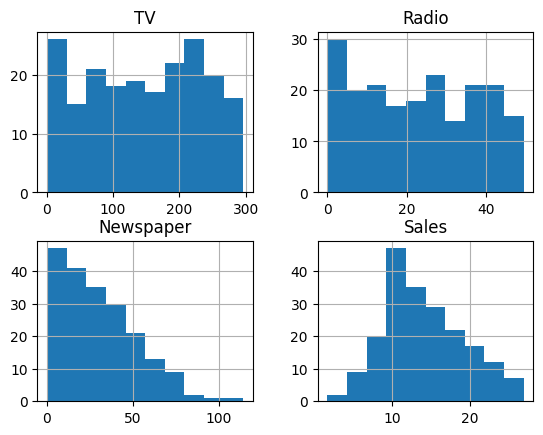

In [10]:
df.hist();

Данные выглядят довольно приятно. У распределений нет длинных хвостов либо резко выделяющихся значений.

__3) Масштабирование признаков.__

При начале работы с данными всегда рекомендуется приводить все признаки к одному масштабу. Это важно для численной устойчивости при работе с данными (рядом с нулем чисел с плавающей точкой больше, чем с области больших чисел). Кроме того, у каждого метода машинного обучения есть свои особенности, требующие масштабирования признаков. Например, для линейных моделей - это ускорение обучения и повышение интерпретируемости модели.

Первый популярный способ масштабирования - нормализация: вычитание среднего из каждого признака и деление на стандартное отклонение (`StandardScaler` в sklearn). Второй популярный способ: вычитание минимума из каждого признака, а затем деление на разницу максимального и минимального значения (`MinMaxScaler` в sklearn).

Мы отмасштабируем данные немного позже.

### Категориальные переменные 

Категориальная переменная у нас одна: `Area`. Она принимает $3$ различных значения.

In [11]:
df['Area'].value_counts()

rural       71
suburban    69
urban       60
Name: Area, dtype: int64

Мы не можем отправить переменную в модель в таком виде. Компьютер понимает только числа. Надо заменить все категории на числа. Вопрос в том, как бы это лучше сделать. Переменная принимает $3$ значения. Возникает соблазн заменить  все `rural` на 1, `suburban` на 2, `urban` на 3. 

Это неправильный подход. Мы вводим искуственный порядок. Каждый из нас может придумать свой порядок. Возникает неоднозначность. Более того, некоторые алгоритмы могут подумать, что третий тип самый лучший, а первый самый плохой. 

Чтобы не путать алгоритм, поступают следующим образом: делают из категориальной переменной много бинарных переменных ( дамми-переменных), они принимают значения $1$ или $0$.

In [12]:
pd.get_dummies(df['Area']).head()

,rural,suburban,urban
0,0,1,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,1,0


Если рынок относится к типу `rural`, то у него в соответствующем столбце будет стоять единичка, а в остальных нули.

__Приятный бонус:__  Не нужно бороться с пропусками в переменных. Для пропусков будет своя дамми и мы не потеряем информации. Такой способ работы с категориями называется One Hot Encoding. 

Дословно можно перевести как одно горячее кодирование (это шутка такая, если вы так скажите какому-то аналитку, он сначала вас не поймёт, а потом, наверное, поугарает, правильно это называется бинаризация категориальных признаков).

В чём минус одного горячего кодирования? Можно обжечься. Если категорий внутри переменной много, то мы переработаем её в слишком большое число столбцов. В конечном итоге это может привести к тому, что модели не хватит наблюдений, чтобы научиться в этом огромном числе столбцов ориентироваться.

In [13]:
pd.get_dummies(df['Area'], drop_first=True).head()

,suburban,urban
0,1,0
1,0,1
2,0,0
3,0,0
4,1,0


Одну из трёх переменных нужно выкинуть. Она избыточная. Вот как мы интерпретируем кодировку:

- **сельский** кодируется как Area_suburban=0 и Area_urban=0
- **suburban** кодируется как Area_suburban=1 и Area_urban=0
- **urban** кодируется как Area_suburban=0 и Area_urban=1

Две дамми переменные захватывают всю информацию об признаке Area и неявно определяют сельскую местность как базовое значение. (В общем случае, если у вас есть категориальный признак с $k$ уровнями, вы создаете фиктивные переменные $k-1$).

In [14]:
df = pd.get_dummies(df, drop_first=True) # ко всем object применится OHE
df.head()

,TV,Radio,Newspaper,Sales,Area_suburban,Area_urban
0,230.1,37.8,69.2,22.1,1,0
1,44.5,39.3,45.1,10.4,0,1
2,17.2,45.9,69.3,9.3,0,0
3,151.5,41.3,58.5,18.5,0,0
4,180.8,10.8,58.4,12.9,1,0


# 3. Как измерить качество модели

Мы решаем задачу регрессии. Нужно прогнозировать действительные числа. Качество прогнозов, которые мы делаем нужно оценивать с помощью какой-то метрики.

## 3.1 Метрики регрессии

In [15]:
from sklearn import metrics  # подгружаем метрики

y_test = [4,20,110]
y_pred = [5,10,100]

Давайте посмотрим на основные метрики качества. Будем обозначать буквой $y_i$ настоящее значение объясняемой переменной. Буквой $\hat y_i$ будем обозначать прогноз.

### Средняя абсолютная ошибка, MAE

$$
MAE = \frac{1}{n}\sum_{i=1}^{n} |y_i - \hat{y}_i|.
$$



In [16]:
metrics.mean_absolute_error(y_test, y_pred)

7.0

Можно нарисовать $MAE$ на картинке. По оси $x$ отложим ошибку прогноза. о оси $y$ будем откладывать то, насколько сильный штраф мы накладываем за такую ошибку. В случае $MAE$ штраф за ошибку в $1$ равен $1$. То есть мы получаем прямую под углом в $45$ градусов. В отрицательную сторону ошибка также штрафуется один к одному. График выглядит, как галочка. 

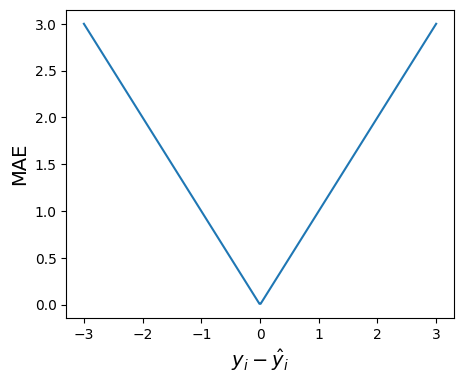

In [17]:
error = np.linspace(-3, 3, 300)
mae = np.abs(error)

plt.figure(figsize=(5,4))
plt.plot(error, mae)
plt.ylabel('MAE', fontsize=14);
plt.xlabel('$y_i - \hat y_i$', fontsize=14);

### Средняя квадратичная ошибка, MSE

$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

In [18]:
metrics.mean_squared_error(y_test, y_pred)

67.0

MSE позволяет штрафовать за ошибку нелинейно. Чем сильнее мы ошибаемся, тем больше наказание. Посчитали, на формулу посмотрели. Если мы ошиблись на 5, то в потери войдёт 25. Если мы ошиблись на 10, то в потери войдёт 100. Чем выше ошибка, тем сильнее потери. При этом наказание растёт квадратично.

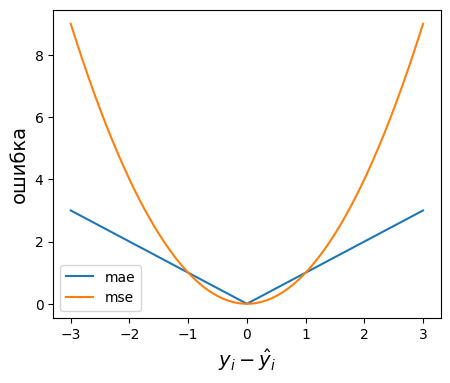

In [19]:
mse = error ** 2

plt.figure(figsize=(5,4))
plt.plot(error, mae, label='mae')
plt.plot(error, mse, label='mse')
plt.ylabel('ошибка', fontsize=14);
plt.xlabel('$y_i - \hat y_i$', fontsize=14)
plt.legend();

У $MSE$ есть проблемы с выбросами. Она очень резко реагирует на них и штрафует за их наличие очень сильно.  Если вы хотите использовать $MSE$ и знаете, что у вас в данных выбросы, от них нужно избавиться заранее. 

__Вопрос:__ а чувствительна ли к выбросам  $MAE$?

На практике из MSE часто извлекают корень. Получается другая метрика, RMSE. Это делают из-за того, что MSE измеряется в квадратных величинах.

In [20]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

8.18535277187245

### Средняя абсолютная процентная ошибка, MAPE 

Часто для нас принципиальным является не то, на сколько лайков мы ошиблись, а то, на сколько процентов мы ошиблись. Метрика, которая отлавливает процентную ошибку, называется $MAPE$ (mean absolute percentage error), средняя абсолютная процентная ошибка. 

$$
MAPE = \frac{1}{n} \sum_{i=1}^n \frac{|y_i - \hat{y}_i|}{y_i}
$$

Если вы предсказали  $1$, а в реальности было  $10$ — это не то же самое, что вы предсказали  $1000$, а в реальности было $1009$: в одном случае вы ошиблись в $10$ раз, а в другом — совсем чуть-чуть. С точки зрения МАЕ или MSE, это две совершенно одинаковые ошибки: $|1009 - 1000| = |10 - 1| = 9$. А если вас интересует относительная ошибка, т.е. на сколько процентов вы ошибаетесь, то следует использовать МАРЕ.

В первой ситуации мы ошиблись на $100 \cdot \frac{|1 - 10|}{10} = 90$ процентов от реального результата. Во второй ситуации на $100 \cdot \frac{|1000 - 1010|}{1009} \approx 1$ процент от реального результата.

Часто MAPE используют в финансах, поскольку там важен процент, который мы получаем в качестве дохода, а не абсолютное значение. 

In [21]:
metrics.mean_absolute_percentage_error(y_test,y_pred)

0.28030303030303033

Этого набора метрик нам для начала хватит. На практике часто используются разные другие метрики. Про них можно подробнее почитать, [например в книге Дьяконова](https://alexanderdyakonov.files.wordpress.com/2018/10/book_08_metrics_12_blog1.pdf) и [конспекте Жени Соколова.](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/lecture-notes/lecture02-linregr.pdf)

In [22]:
def print_metrics(y_test,y_pred):
    print('MAE:', "%.4f" % metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', "%.4f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('MAPE:', "%.4f" % metrics.mean_absolute_percentage_error(y_test,y_pred))

print_metrics(y_test,y_pred)

MAE: 7.0000
RMSE: 8.1854
MAPE: 0.2803


Для задачи классификации у нас будет другой набор метрик, с которым мы познакомимся позже.

## 3.2 Разбиение выборки на обучающую и тестовую

Когда мы обучаем модель на тренировочных данных, нам хочется понять насколько хорошо она работает в боевых условиях. Выборка, на которой мы учимся, не подходит для этих целей. Так как знания об этих объектах уже будут лежать в нашей модели, а в реальной жизни будут встречаться и новые, ранее неизвестные объекты. 

Разобьём выборку на две части: обучающую и тестовую. Будем учить модель только на обучающей части. Тогда при обучении алгоритм не увидит тестовые примеры. Значит можно использовать её для имитации этих самых новых объектов из реальной жизни и посмотреть какое на них будет качество.

In [23]:
from sklearn.model_selection import train_test_split  # функция для деления 

# делим в пропорции 80 к 20
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42)

In [24]:
y_train = df_train['Sales'].to_numpy()
y_test = df_test['Sales'].to_numpy()

X_train = df_train.drop('Sales', axis=1).to_numpy()
X_test = df_test.drop('Sales', axis=1).to_numpy()

feature_names = df_train.drop('Sales', axis=1).columns

In [25]:
X_train.shape, X_test.shape

((160, 5), (40, 5))

# 4. Обучаем модель

Ниже мы будем активно использовать следующие два понятия:

__Параметры__ — это величины, которые мы настраиваем в процессе обучения по обучающей выборке. 

__Гиперпараметры__ — это величины, которые мы должны установить до начала обучения модели. Гиперпараметры не настраиваются по обучающей выборке в процессе обучения модели.

## 4.1 Наивный прогноз 

Чтобы понять, насколько хорошо работает модель, надо с чем-то сравнивать результат её работы. Давайте посчитаем на обучающей выборке средние продажи и используем это значение в качестве прогноза для всех наблюдений тестовой выборки. C получившимся качеством мы будем сравнивать все остальные модели. Такую, самую простую модель, обычно называют бейзлайном.

In [26]:
y_mean = np.mean(y_train)                     # посчитали среднее 
y_pred_naive = np.ones(len(y_test)) * y_mean  # спрогнозировали им лайки

In [27]:
print_metrics(y_test, y_pred_naive)

MAE: 4.9625
RMSE: 5.6315
MAPE: 0.4443


__Вопрос:__ Что означают эти числа? Насколько плохи наши дела?

## 4.2 Интерфейс Scikit-Learn

Scikit-Learn, или коротко Sklearn - библиотека, в которой реализованы практически все используемые сегодня алгоритмы машинного обучения. Нам необходимо познакомиться с интерфейсом библиотеки, чтобы понимать, как ее можно использовать на практике. 

Для реализации алгоритмов машинного обучения в `sklearn` всегда используется один интерфейс - класс с методами `fit(X, Y)` для обучения модели по обучающей выборке $X, Y$ и `predict(X)` для возвращения предсказаний на выборке $X$. При создании класса можно указывать дополнительные параметры, влияющие на работу алгоритма машинного обучения.

Например, такова будет логика работы класса линейной регрессии, которую мы подробно изучим на следующих семинарах:

* При создании класса нужно запомнить коэффициент регуляризации;
* Задача функции fit - по выборке X и Y найти веса w и сохранить их внутри класса в self.w;
* Задача функции predict - по весам self.w и X вернуть предсказания $Y$.

Если бы мы не использовали класс, нам пришлось бы передавать веса w в функцию predict каждый раз, когда мы захотели бы сделать предсказания, это неудобно (особенно если таких вспомогательных переменных много). А так веса хранятся внутри класса, и мы можем даже не догадываться об их существовании (если класс писали не мы).

Помимо алгоритмов обучения и предсказания для разных методов, в sklearn реализовано много вспомогательного функционала для предобработки данных, визуализации данных, вычисления метрик качества и т. д. В ходе следующих семинаров мы постепенно познакомимся с этим функционалом библиотеки.


## 4.3 Линейная регрессия

Давайте обучим наш первый алгоритм. Сначала обучим, потом будем разбираться что произошло. Это будет линейная регрессия. 

In [28]:
#Что хотим увидеть
from sklearn.linear_model import LinearRegression # подгрузили модель

# Объявили модель
model_regression = LinearRegression()

# Обучили модель на тренировочной выборке 
model_regression.fit(X_train, y_train)

# Сделали прогнозы на тестовой выборке 
y_pred_regr = model_regression.predict(X_test)

In [29]:
print_metrics(y_test, y_pred_regr)

MAE: 1.4803
RMSE: 1.7993
MAPE: 0.1540


__Вопрос:__ Что означают эти числа? Насколько плохи наши дела?

Мы с вами только что обучили следующее уравнение:

$$
Sales = w_0 + w_1 \cdot TV + w_2 \cdot Radio + w_3 \cdot Newspaper + w_4 \cdot Area\ suburban + w_5 \cdot Area\ urban
$$

Мы пытаемся объяснить продажи через расходы на маркетинг. Каждая объясняющая переменная вносит свой вклад с каким-то коэффициентом. Давайте посмотрим на них:

In [30]:
model_regression.coef_  # коэффициенты модели

array([ 0.04482017,  0.18995499,  0.00281706, -0.22006653, -0.11379965])

In [31]:
model_regression.intercept_

3.0534457425468613

In [32]:
feature_names

Index(['TV', 'Radio', 'Newspaper', 'Area_suburban', 'Area_urban'], dtype='object')

Выходит, что наше уравнение имеет вид 

$$
Sales = 3.053 + 0.045 \cdot TV + 0.189 \cdot Radio + 0.003 \cdot Newspaper - -0.220 \cdot Area\ suburban -0.114 \cdot Area\ urban.
$$

Если к нам приходит новое наблюдение, мы подставляем его в уравнение и получаем прогноз. Коэффициенты в линейной регрессии подбираются с помощью минимизации MSE. Это делается градиентным спуском. Подробнее об этом мы поговорим в следующем семинаре.

__Вопрос:__ Попробуйте обучить модель на прологарифмированных данных. Как думаете, улучшится ли её качество? Как в случае такой модели строится прогноз?

## 4.4 Метод ближайших соседей

Метод ближайших соседей — это очень простой эвристический алгоритм. У метода нет параметров. Мы запоминаем всю обучающую выборку, а дальше смотрим, какие наблюдения оказываются ближе всего к нашему. 

- В случае классификации прогнозом будет самый частый класс.
- В случае регрессии прогнозом будет среднее.

Перед тем, как запускать алгоритм, надо будет выбрать как именно считать расстояния. У нас будет две опции: манхеттенская метрика и евклидова метрика.

### Задача 1 (классификация)

Предположим, мы решаем задачу классификации на три класса по двум признакам и используем метод $k$ ближайших соседей с $k = 3$ и манхэттанской метрикой. Мы имеем следующую обучающую выборку:

| Признак 1 | Признак 2 | Класс |
|-----------|-----------|-------|
| 1         | -1        | 1     |
| 2         | 2         | 1     |
| 3         | 2         | 2     |
| 1         | 0         | 3     |
| 2         | -2        | 3     |

Каковы будут предсказания для объекта $x=(2, -1)$?

__Решение:__

Алгоритм предсказания kNN для задачи классификации:
1. Вычислить расстояние от каждого объекта обучающей выборки до тестового объекта.
1. Найти k объектов обучающей выборки (соседей) с наименьшим расстоянием до тестового объекта.
1. Вернуть наиболее встречающийся класс среди k соседей.

Вычислим расстояния. Расстояние от первого объекта в обучении до тестового объекта $x$ (манхэттэнская метрика):

$$|1-2| + |-1-(-1)| = 1.$$

Аналогично для 2-5 объектов: получатся расстояния 3, 4, 2, 1.

Находим 3 ближайших объекта: это объекты с номерами 1, 4, 5 (расстояния 1, 2, 1 соответственно). Эти три объекта относятся к классам 1, 3, 3. Чаще всего встречается класс 3, поэтому предсказываем 3.

### Задача 2 (регрессия)

Предположим, мы решаем задачу регрессии по двум признакам и используем метод k ближайших соседей с k=3 и манхэттанской метрикой. Мы имеем следующую обучающую выборку:

| Признак 1 | Признак 2 | Ответ |
|-----------|-----------|-------|
| 1         | -1        | 3.5     |
| 2         | 2         | 2.3     |
| 3         | 2         | 1.7     |
| 1         | 0         | -0.4     |
| 2         | -2        | 0.1     |

Каковы будут предсказания для объекта $x=(2, -1)$?

__Решение:__

Предсказания kNN для регрессии отличаются от предсказаний для классификации только финальным шагом: вместо поиска наиболее часто встречающегося класса нужно усреднить ответы на соседях. Признаки в этой задаче те же, что в задаче 1, поэтому соседей мы уже знаем: это объекты с номерами 1, 4, 5. На них мы имеем ответы 3.5, -0.3, 0.1. Усредним их: (3.5-0.4+0.1)/3 = 1.1. Предсказываем 1.1.

In [33]:
from sklearn.neighbors import KNeighborsRegressor

model_knn = KNeighborsRegressor(n_neighbors=20)

model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

print_metrics(y_test, y_pred_knn)

MAE: 1.6471
RMSE: 2.1130
MAPE: 0.1290


__Вопрос:__ Что означают эти числа? Насколько плохи наши дела?

Два самых важных гиперпараметры метода kNN — это число соседей k и метрика. Используя разные комбинации этих гиперпараметров, можно получать совершенно разное качество работы алгоритма. Гиперпараметры обычно настраивают по валидационной выборке или используя кросс-валидацию.

При использовании kNN очень важно нормировать данные. Внутри метода ближайшего соседа мы считаем расстояния. Пусть у нас есть два человека: Вася и Петя. Вася весит $90$ кг. Петя $60$ кг. У Васи рост $1.9$ метра. У Пети $1.7$ метра. Посчитаем евклидово расстояние между парнями: 

$$
\rho(\text{Вася}, \text{Петя}) = \sqrt{(1.9 - 1.7)^2 + (90 - 60)^2} = \sqrt{0.04 + 900}. 
$$

Какой из признаков вносит больший вклад в расстояние? Вес. Просто из-за того, что он измерен в другой шкале. Это будет путать алгоритм, когда он будет искать расстояния. Чтобы избежать такой путанницы, данные нужно отскалировать. То есть привести к одной шкале. Например, с помощью `StandardScaler`

$$
x^{*} = \frac{x − \bar x}{se(x)}
$$

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [35]:
model_knn = KNeighborsRegressor(n_neighbors=20)
model_knn.fit(X_train_scale, y_train)
y_pred_knn = model_knn.predict(X_test_scale)

print_metrics(y_test, y_pred_knn)

MAE: 2.4435
RMSE: 3.0576
MAPE: 0.2264


У нас качество испортилось :( Как думаете, почему?

Давайте посмотрим, как будет вести себя алгоритм при увеличении числа соседей.

При $k=1$ вокруг каждого объекта обучающей выборки создается область его класса. Если, к примеру, в "большую" область одного класса случайно попал один шумовой объект другого класса, вокруг этого шумового объекта будет "остров" предсказания другого класса. Это нелогично и говорит о переобучении.

При $k$, равном числу объектов в выборке, для всех объектов будет предсказываться одно и то же, что вновь говорит о низком качестве работы классификатора. Получается, что качество kNN при увеличении $k$ должно сначала расти, а потом падать, и оптимум будем где-то посередине.

In [36]:
for k in range(1, 20):
    y_pred = KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train).predict(X_test)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    print(f"k = {k}; mae = {mae:.3f}")

k = 1; mae = 1.370
k = 2; mae = 1.357
k = 3; mae = 1.281
k = 4; mae = 1.219
k = 5; mae = 1.189
k = 6; mae = 1.295
k = 7; mae = 1.212
k = 8; mae = 1.268
k = 9; mae = 1.233
k = 10; mae = 1.239
k = 11; mae = 1.325
k = 12; mae = 1.392
k = 13; mae = 1.431
k = 14; mae = 1.469
k = 15; mae = 1.519
k = 16; mae = 1.539
k = 17; mae = 1.566
k = 18; mae = 1.607
k = 19; mae = 1.615


Обратите внимание, что мы используем здесь тестовую выборку для подбора гиперпараметра $k$. Она начинает участвовать в обучении. Если нам хочется замерить качество алгоритма, нам нужна нова тестовая выборка. Обычно выборку делят на три части: __обучающую, валидационную и тестовую.__ На валидационной подбирают гиперпараметры. 

Иногда алгоримы оказываются сложными и валидационных выборок приходится заводить несколько. Все ради того, чтобы избежать __переобучения.__

![](https://miro.medium.com/max/875/1*_7OPgojau8hkiPUiHoGK_w.png)